# **Task 8: Traffic Sign Recognition**

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 0 = all logs, 1 = info, 2 = warnings, 3 = errors only
import tensorflow as tf

2025-09-05 10:00:19.923208: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757066420.093901      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757066420.143821      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### **Explanation:**

We import Python, Keras, TensorFlow, OpenCV (optional, but PIL is enough for resizing).

These tools are exactly what your project description asks for.

In [4]:
# Core libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Sklearn for metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score


In [5]:

DATA_PATH = '/kaggle/input/gtsrb-german-traffic-sign/'  
IMG_HEIGHT, IMG_WIDTH = 32, 32
NUM_CLASSES = 43



# **Load and Preprocess Data**

## **Explanation:**

1. Resize and normalize images → matches project requirement


2. Convert labels to categorical → multi-class classification


3. Split validation data → evaluate during training

In [6]:
# Load training images
def load_data(data_dir):
    images, labels = [], []
    for class_id in range(NUM_CLASSES):
        class_folder = os.path.join(data_dir, 'Train', str(class_id))
        if not os.path.isdir(class_folder):
            continue
        for img_name in os.listdir(class_folder):
            img_path = os.path.join(class_folder, img_name)
            image = Image.open(img_path).resize((IMG_WIDTH, IMG_HEIGHT))
            images.append(np.array(image))
            labels.append(class_id)
    return np.array(images), np.array(labels)

X_train, y_train = load_data(DATA_PATH)



In [7]:
X_train.shape

(39209, 32, 32, 3)

In [8]:
y_train.shape

(39209,)

In [9]:
# Load test data
test_df = pd.read_csv(os.path.join(DATA_PATH, 'Test.csv'))
X_test, y_test = [], []
for path, class_id in zip(test_df['Path'], test_df['ClassId']):
    img_path = os.path.join(DATA_PATH, path)
    image = Image.open(img_path).resize((IMG_WIDTH, IMG_HEIGHT))
    X_test.append(np.array(image))
    y_test.append(class_id)
X_test = np.array(X_test)
y_test = np.array(y_test)

# Normalize to [0,1]
X_train, X_test = X_train / 255.0, X_test / 255.0

# One-hot encode labels
y_train_cat = to_categorical(y_train, NUM_CLASSES)
y_test_cat = to_categorical(y_test, NUM_CLASSES)

# Split validation set
X_train, X_val, y_train_cat, y_val_cat = train_test_split(X_train, y_train_cat, test_size=0.2, random_state=42)


## **Visualize Class Distribution**

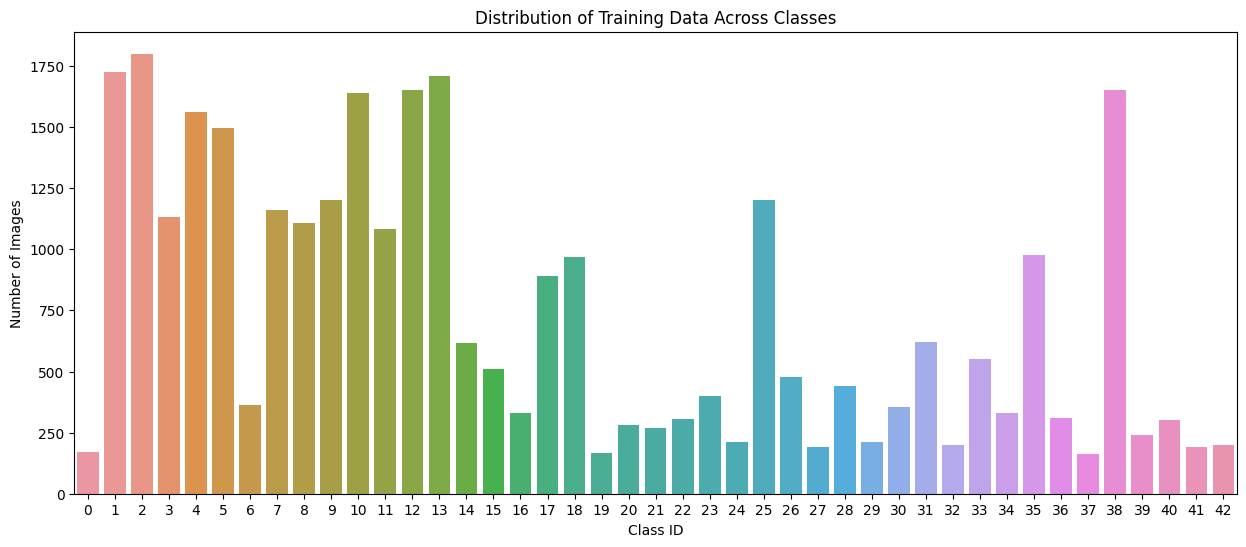

In [10]:
plt.figure(figsize=(15,6))
sns.countplot(x=np.argmax(y_train_cat, axis=1))
plt.title("Distribution of Training Data Across Classes")
plt.xlabel("Class ID")
plt.ylabel("Number of Images")
plt.show()


# **Data Augmentation (Bonus)**

 ## Explanation:

Optional bonus step to improve performance

Only used during training

In [11]:
train_aug = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    fill_mode='nearest'
)
train_aug.fit(X_train)


# **Build CNN Models**

**Custom CNN (Required)**

In [12]:
def build_custom_cnn():
    model = Sequential([
        Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        Conv2D(32, (3,3), activation='relu', padding='same'),
        MaxPooling2D(2,2),
        Conv2D(64, (3,3), activation='relu', padding='same'),
        MaxPooling2D(2,2),
        Conv2D(128, (3,3), activation='relu', padding='same'),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(NUM_CLASSES, activation='softmax')
    ])
    model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


# **Train and Evaluate Function**

In [13]:
def train_evaluate(model, model_name, use_aug=False):
    print(f"Training {model_name} {'with augmentation' if use_aug else 'without augmentation'}")
    callbacks = [EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
                 ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)]
    
    if use_aug:
        history = model.fit(train_aug.flow(X_train, y_train_cat, batch_size=64),
                            validation_data=(X_val, y_val_cat),
                            epochs=20, callbacks=callbacks)
    else:
        history = model.fit(X_train, y_train_cat, validation_data=(X_val, y_val_cat),
                            batch_size=64, epochs=20, callbacks=callbacks)
    
    # Evaluate
    test_loss, test_acc = model.evaluate(X_test, y_test_cat)
    print(f"Test Accuracy: {test_acc*100:.2f}%")
    
    # Confusion Matrix
    y_pred = np.argmax(model.predict(X_test), axis=1)
    cm = confusion_matrix(y_test, y_pred)
    
    return history, test_acc, cm


In [14]:
custom_cnn = build_custom_cnn()
hist_custom, acc_custom, cm_custom = train_evaluate(custom_cnn, "Custom CNN", use_aug=True)

I0000 00:00:1757066799.968520      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Training Custom CNN with augmentation
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1757066803.640225     135 service.cc:148] XLA service 0x7ed528004f60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757066803.640971     135 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1757066803.936321     135 cuda_dnn.cc:529] Loaded cuDNN version 90300


  6/491 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - accuracy: 0.0206 - loss: 3.7478

I0000 00:00:1757066806.267749     135 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


491/491 ━━━━━━━━━━━━━━━━━━━━ 24s 39ms/step - accuracy: 0.2206 - loss: 2.8093 - val_accuracy: 0.6589 - val_loss: 1.0602 - learning_rate: 0.0010
Epoch 2/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - accuracy: 0.6387 - loss: 1.0855 - val_accuracy: 0.9254 - val_loss: 0.3060 - learning_rate: 0.0010
Epoch 3/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - accuracy: 0.8444 - loss: 0.4744 - val_accuracy: 0.9629 - val_loss: 0.1230 - learning_rate: 0.0010
Epoch 4/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - accuracy: 0.9137 - loss: 0.2693 - val_accuracy: 0.9816 - val_loss: 0.0747 - learning_rate: 0.0010
Epoch 5/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - accuracy: 0.9422 - loss: 0.1804 - val_accuracy: 0.9906 - val_loss: 0.0376 - learning_rate: 0.0010
Epoch 6/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - accuracy: 0.9558 - loss: 0.1403 - val_accuracy: 0.9922 - val_loss: 0.0285 - learning_rate: 0.0010
Epoch 7/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - accuracy: 0.9682 - loss: 0.1034

In [15]:
def plot_cm(cm, model_name):
    plt.figure(figsize=(12,10))
    sns.heatmap(cm, annot=False, cmap='Blues', fmt='g')
    plt.title(f'Confusion Matrix: {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


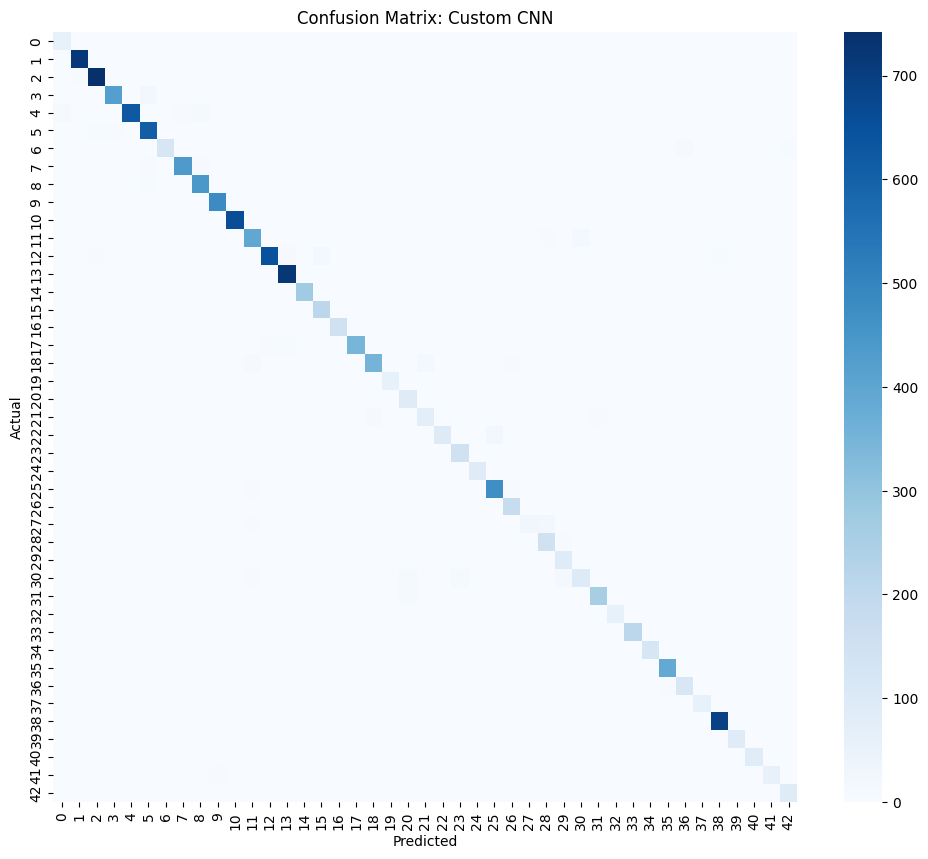

In [16]:
plot_cm(cm_custom, "Custom CNN")

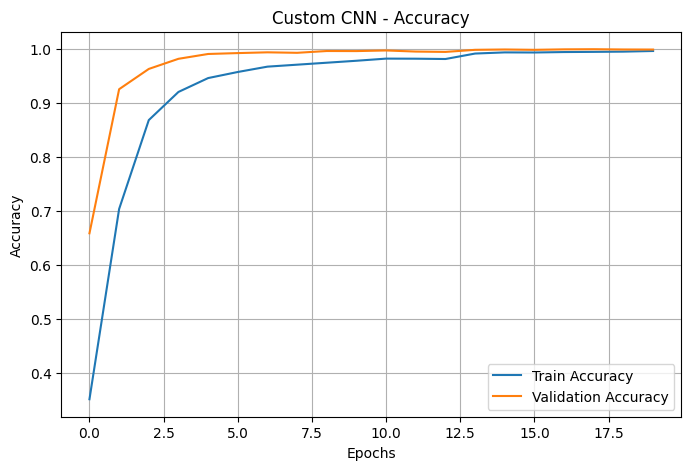

In [17]:
# Plot Accuracy separately
def plot_accuracy(history, model_name):
    plt.figure(figsize=(8,5))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f"{model_name} - Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()



# Custom CNN
plot_accuracy(hist_custom, "Custom CNN")




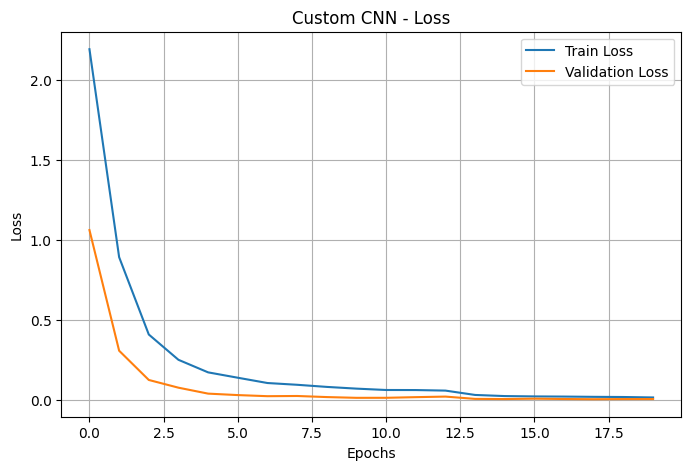

In [18]:

# Plot Loss separately
def plot_loss(history, model_name):
    plt.figure(figsize=(8,5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f"{model_name} - Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss(hist_custom, "Custom CNN")



# **DenseNet121 WITHOUT Data Augmentation**

In [19]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Flatten, Dense, Dropout)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [20]:
# --- Config ---
DATA_PATH = '/kaggle/input/gtsrb-german-traffic-sign/'
IMG_HEIGHT, IMG_WIDTH = 32, 32
NUM_CLASSES = 43
EPOCHS = 20
BATCH_SIZE = 64

In [21]:
def load_data(data_dir):
    images, labels = [], []
    for class_id in range(NUM_CLASSES):
        class_path = os.path.join(data_dir, 'Train', str(class_id))
        if not os.path.isdir(class_path):
            continue
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            image = Image.open(img_path).resize((IMG_WIDTH, IMG_HEIGHT))
            images.append(np.array(image))
            labels.append(class_id)
    return np.array(images), np.array(labels)

X_train, y_train = load_data(DATA_PATH)

In [22]:
# Test Data
test_df = pd.read_csv(os.path.join(DATA_PATH, 'Test.csv'))
X_test, y_test = [], []
for img_path, class_id in zip(test_df['Path'], test_df['ClassId']):
    full_path = os.path.join(DATA_PATH, img_path)
    image = Image.open(full_path).resize((IMG_WIDTH, IMG_HEIGHT))
    X_test.append(np.array(image))
    y_test.append(class_id)

X_test, y_test = np.array(X_test), np.array(y_test)

In [23]:
# --- Preprocessing ---
X_train, X_test = X_train.astype("float32")/255.0, X_test.astype("float32")/255.0
y_train, y_test_cat = to_categorical(y_train, NUM_CLASSES), to_categorical(y_test, NUM_CLASSES)


In [24]:
# Validation Split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


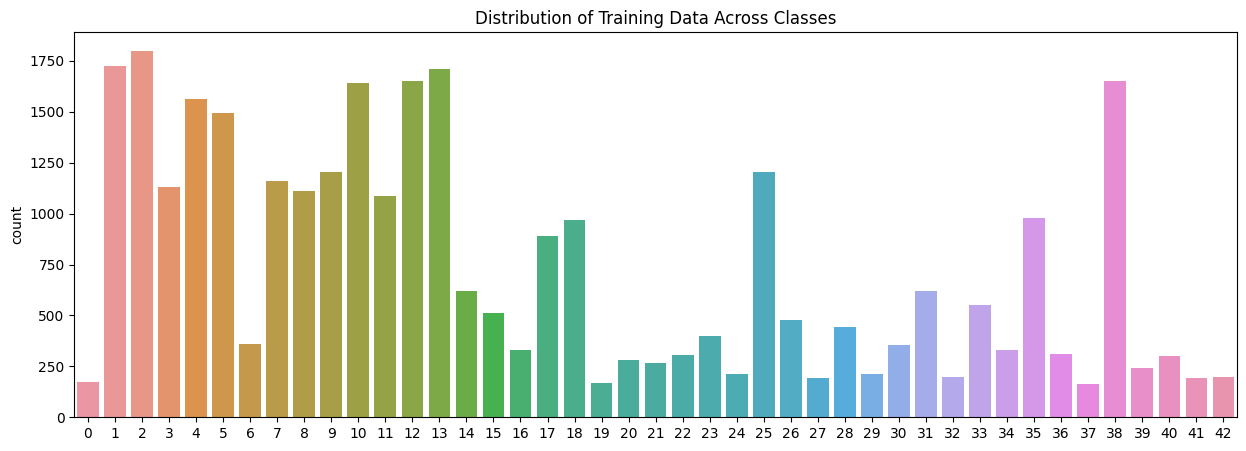

In [25]:
# Distribution plot
plt.figure(figsize=(15, 5))
sns.countplot(x=np.argmax(y_train, axis=1))
plt.title('Distribution of Training Data Across Classes')
plt.show()

In [26]:
# --- Model ---
def build_densenet():
    base_model = DenseNet121(weights="imagenet", include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    base_model.trainable = False
    inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    x = base_model(inputs, training=False)
    x = Flatten()(x)
    x = Dense(512, activation="relu")(x)
    x = Dropout(0.5)(x)
    outputs = Dense(NUM_CLASSES, activation="softmax")(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(1e-3), loss="categorical_crossentropy", metrics=["accuracy"])
    return model

model = build_densenet()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [27]:
# --- Training ---
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=1e-5)
]


In [28]:
history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)


Epoch 1/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 64s 71ms/step - accuracy: 0.3698 - loss: 2.2575 - val_accuracy: 0.6400 - val_loss: 1.1132 - learning_rate: 0.0010
Epoch 2/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.6121 - loss: 1.1821 - val_accuracy: 0.7116 - val_loss: 0.8699 - learning_rate: 0.0010
Epoch 3/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.6817 - loss: 0.9443 - val_accuracy: 0.7615 - val_loss: 0.7118 - learning_rate: 0.0010
Epoch 4/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.7315 - loss: 0.7869 - val_accuracy: 0.7965 - val_loss: 0.6307 - learning_rate: 0.0010
Epoch 5/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.7562 - loss: 0.7226 - val_accuracy: 0.8041 - val_loss: 0.5893 - learning_rate: 0.0010
Epoch 6/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.7835 - loss: 0.6410 - val_accuracy: 0.8331 - val_loss: 0.5145 - learning_rate: 0.0010
Epoch 7/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.8045 - loss: 0

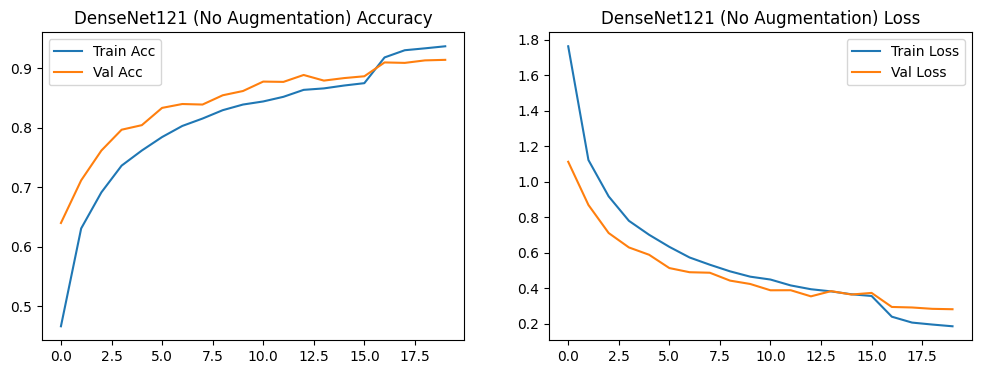

In [29]:
# --- Visualization ---
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.legend(); plt.title("DenseNet121 (No Augmentation) Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend(); plt.title("DenseNet121 (No Augmentation) Loss")
plt.show()

In [30]:
loss, acc = model.evaluate(X_test, y_test_cat, verbose=0)
print(f"Test Accuracy (No Augmentation): {acc*100:.2f}%")

Test Accuracy (No Augmentation): 60.04%


395/395 ━━━━━━━━━━━━━━━━━━━━ 27s 41ms/step


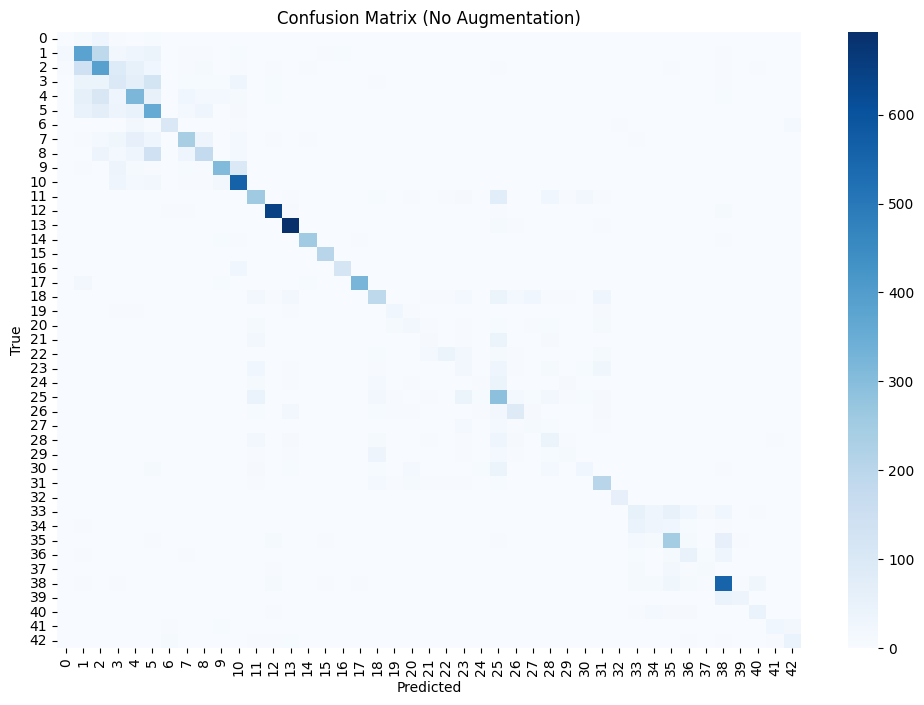

In [31]:
# --- Confusion Matrix ---
y_pred = np.argmax(model.predict(X_test), axis=1)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12,8))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.title("Confusion Matrix (No Augmentation)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [32]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.10      0.03      0.05        60
           1       0.53      0.53      0.53       720
           2       0.44      0.51      0.47       750
           3       0.24      0.22      0.23       450
           4       0.48      0.48      0.48       660
           5       0.43      0.57      0.49       630
           6       0.78      0.67      0.72       150
           7       0.69      0.53      0.60       450
           8       0.59      0.39      0.47       450
           9       0.81      0.65      0.72       480
          10       0.70      0.85      0.77       660
          11       0.57      0.62      0.59       420
          12       0.90      0.94      0.92       690
          13       0.87      0.96      0.92       720
          14       0.94      0.93      0.94       270
          15       0.95      0.98      0.96       210
          16       0.94      0.80      0.86       150
    

# **DenseNet121 WITH Data Augmentation**

In [33]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# --- Data Augmentation ---
datagen = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    fill_mode="nearest"
)
datagen.fit(X_train)

In [34]:
def build_densenet():
    base_model = DenseNet121(weights="imagenet", include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    base_model.trainable = False
    inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    x = base_model(inputs, training=False)
    x = Flatten()(x)
    x = Dense(512, activation="relu")(x)
    x = Dropout(0.5)(x)
    outputs = Dense(NUM_CLASSES, activation="softmax")(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(1e-3), loss="categorical_crossentropy", metrics=["accuracy"])
    return model

model = build_densenet()

In [35]:
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


491/491 ━━━━━━━━━━━━━━━━━━━━ 74s 96ms/step - accuracy: 0.3269 - loss: 2.4096 - val_accuracy: 0.5916 - val_loss: 1.2619 - learning_rate: 0.0010
Epoch 2/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - accuracy: 0.5320 - loss: 1.4435 - val_accuracy: 0.6642 - val_loss: 1.0359 - learning_rate: 0.0010
Epoch 3/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.5871 - loss: 1.2451 - val_accuracy: 0.6924 - val_loss: 0.9236 - learning_rate: 0.0010
Epoch 4/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.6186 - loss: 1.1338 - val_accuracy: 0.7144 - val_loss: 0.8333 - learning_rate: 0.0010
Epoch 5/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.6410 - loss: 1.0677 - val_accuracy: 0.7455 - val_loss: 0.7766 - learning_rate: 0.0010
Epoch 6/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - accuracy: 0.6571 - loss: 1.0115 - val_accuracy: 0.7582 - val_loss: 0.7304 - learning_rate: 0.0010
Epoch 7/20
491/491 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.6711 - loss: 0.9650

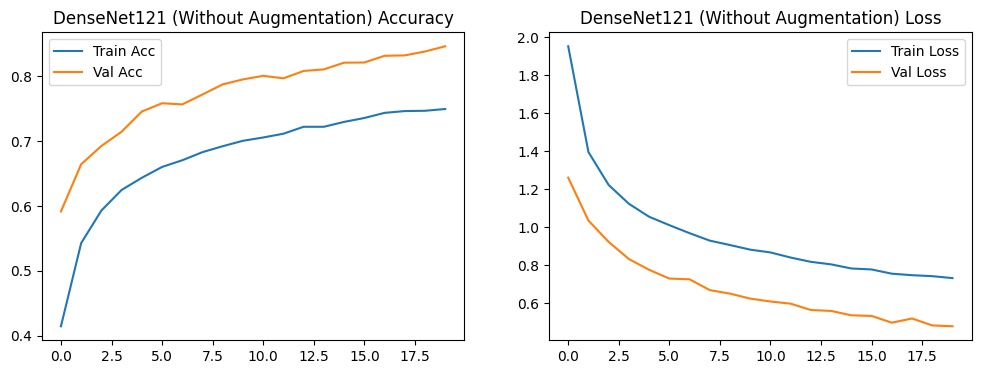

In [36]:
plt.figure(figsize=(12,4))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.legend(); plt.title("DenseNet121 (Without Augmentation) Accuracy")

# Loss
plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend(); plt.title("DenseNet121 (Without Augmentation) Loss")

plt.show()



395/395 ━━━━━━━━━━━━━━━━━━━━ 25s 39ms/step


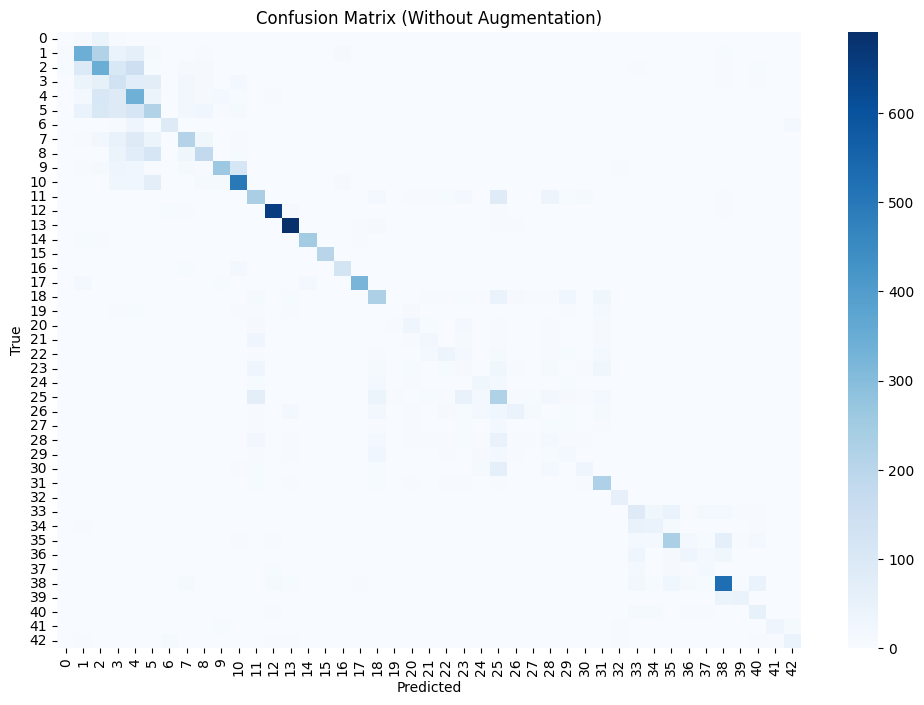

In [37]:
y_pred = np.argmax(model.predict(X_test), axis=1)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12,8))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.title("Confusion Matrix (Without Augmentation)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [38]:
loss, acc = model.evaluate(X_test, y_test_cat, verbose=0)
print(f"Test Accuracy (With Augmentation): {acc*100:.2f}%")

Test Accuracy (With Augmentation): 56.90%
